In [11]:
%pip install -r requirements.txt
%pip install scikit-learn

import sklearn as sk  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
#load the datasets from the .npy files
circle_data   = np.load('Data/circle.npy')  
square_data   = np.load('Data/square.npy')
triangle_data = np.load('Data/triangle.npy')
hexagon_data  = np.load('Data/hexagon.npy')
octagon_data  = np.load('Data/octagon.npy')

#label the datasets
circle_labels   = np.full(len(circle_data),   0)
square_labels   = np.full(len(square_data),   1)
triangle_labels = np.full(len(triangle_data), 2)
hexagon_labels  = np.full(len(hexagon_data),  3)
octagon_labels  = np.full(len(octagon_data),  4)
CLASS_NAMES = np.array(['circle', 'square', 'triangle', 'hexagon', 'octagon'])
NUM_CLASSES = len(CLASS_NAMES)

#combine the datasets
X = np.concatenate([circle_data, square_data, triangle_data,
                    hexagon_data, octagon_data], axis=0)
y = np.concatenate([circle_labels, square_labels, triangle_labels,
                    hexagon_labels, octagon_labels], axis=0)

In [13]:
from sklearn.model_selection import train_test_split

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Normalize the pixel values
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32')  / 255.0

#Reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test  = X_test.reshape(X_test.shape[0], 28, 28, 1)

#One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 5)
y_test  = tf.keras.utils.to_categorical(y_test,  5)





In [14]:
from tensorflow.keras import layers, models

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Flatten(),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(5, activation='softmax')  # e.g., 5 shapes
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()


/Users/siakhorsand/Desktop/Projects/NN/Shape_Recognition-/vash/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,045 (1.49 MB)

 Trainable params: 390,085 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 126s 15ms/step - accuracy: 0.8814 - loss: 0.2873 - val_accuracy: 0.8815 - val_loss: 0.2861
Epoch 2/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 131s 16ms/step - accuracy: 0.8853 - loss: 0.2783 - val_accuracy: 0.8837 - val_loss: 0.2853
Epoch 3/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 123s 15ms/step - accuracy: 0.8885 - loss: 0.2706 - val_accuracy: 0.8836 - val_loss: 0.2821
Epoch 4/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 124s 15ms/step - accuracy: 0.8909 - loss: 0.2653 - val_accuracy: 0.8699 - val_loss: 0.3072
Epoch 5/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 126s 15ms/step - accuracy: 0.8931 - loss: 0.2595 - val_accuracy: 0.8810 - val_loss: 0.2917
Epoch 6/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 127s 15ms/step - accuracy: 0.8958 - loss: 0.2526 - val_accuracy: 0.8797 - val_loss: 0.3040
Epoch 7/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 130s 15ms/step - accuracy: 0.8980 - loss: 0.2468 - val_accuracy: 0.8806 - val_loss: 0.2980
Epoch 8/20
8414/8414 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step - accuracy: 

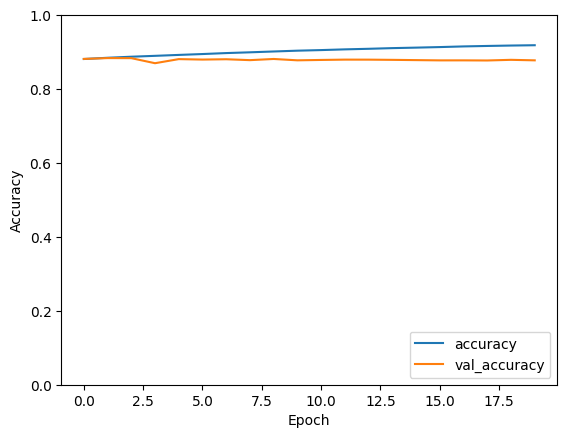

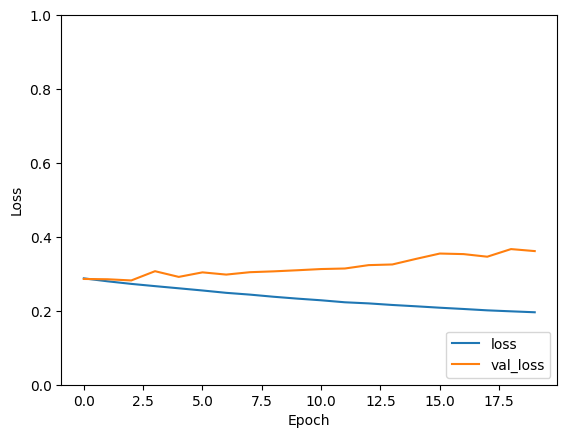

4207/4207 - 10s - 2ms/step - accuracy: 0.8776 - loss: 0.3616


0.8776481747627258


In [16]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test)
)
#plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

#Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

#Save the model
model.save('shapes_model.h5')


In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

model.save("shape_model.h5")
print("Model saved as shape_model.h5")

4207/4207 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8794 - loss: 0.2943


Test Accuracy: 0.8788
Model saved as shape_model.h5


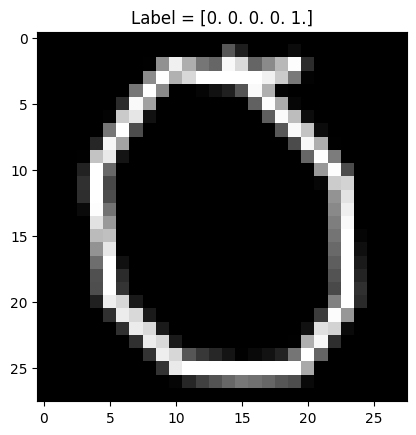

In [15]:
import matplotlib.pyplot as plt

index = 11000
plt.imshow(X_train[index].squeeze(), cmap='gray')
plt.title(f"Label = {y_train[index]}")
plt.show()

In [ ]:
# Example quick check
import numpy as np

preds = model.predict(X_test[:10])
pred_classes = np.argmax(preds, axis=1)
print("Predicted:", pred_classes)
print("True labels:", y_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: [4 3 0 0 3 4 0 1 2 1]
True labels: [[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
